<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/pybfs/blob/main/notebooks/pybfs_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyBFS Sample Problem

This notebook illustrates how to use the PyBFS code to perform baseflow separation and baseflow forecasting.


## Import required packages

In [8]:
# Import the pybfs code and other required packages.

import pybfs as bfs  # For this to work, you must copy the pybfs.py file to the colab file space
import pandas as pd
import numpy as np


## Load data

Before running this code block, you will need to upload two CSV files, one with the streamflow data and one with the site parameters.

In [9]:
streamflow_file  = '2312200_data.csv'
params_file = 'bfs_params_50.csv'

# Load streamflow data
print("Loading streamflow data...")
streamflow_data = pd.read_csv(streamflow_file)

# Load site parameters
print("Loading site parameters...")
bfs_params_usgs = pd.read_csv(params_file)

# Get parameters for specific site
site_number = 2312200
print(f"Extracting parameters for site {site_number}...")
basin_char, gw_hyd, flow = bfs.get_values_for_site(bfs_params_usgs, site_number)

# Extract basin characteristics
area, lb, x1, wb, por = basin_char[0], basin_char[1], basin_char[2], basin_char[3], basin_char[4]
ws = wb / 2

# Extract groundwater hydraulic parameters
alpha, beta, ks, kb, kz = gw_hyd[0], gw_hyd[1], gw_hyd[2], gw_hyd[3], gw_hyd[4]

# Extract flow metrics
qthresh, rs, rb1, rb2, prec, fr4rise = flow[0], flow[1], flow[2], flow[3], flow[4], flow[5]

print(f"\nBasin characteristics:")
print(f"  Area: {area}, Length: {lb}, Width: {wb}")
print(f"  Porosity: {por}")

Loading streamflow data...
Loading site parameters...
Extracting parameters for site 2312200...

Basin characteristics:
  Area: 371200000.0, Length: 19383.1, Width: 420.959
  Porosity: 0.15


## Generate Baseflow Table

In [10]:
print("\nGenerating baseflow table...")
SBT = bfs.base_table(lb, x1, wb, beta, kb, streamflow_data, por)
print(f"Baseflow table generated with {len(SBT)} rows")


Generating baseflow table...
Baseflow table generated with 1000 rows


## Run PyBFS for baseflow separation


Running PyBFS baseflow separation...
PyBFS completed for 365 time steps

=== Results Summary ===
Total observed flow: 85129801.65
Total simulated flow: 57936846.61
Total baseflow: 39658625.89
Total surface flow: 13483044.62
Total direct runoff: 4822992.70

Plotting baseflow simulation...


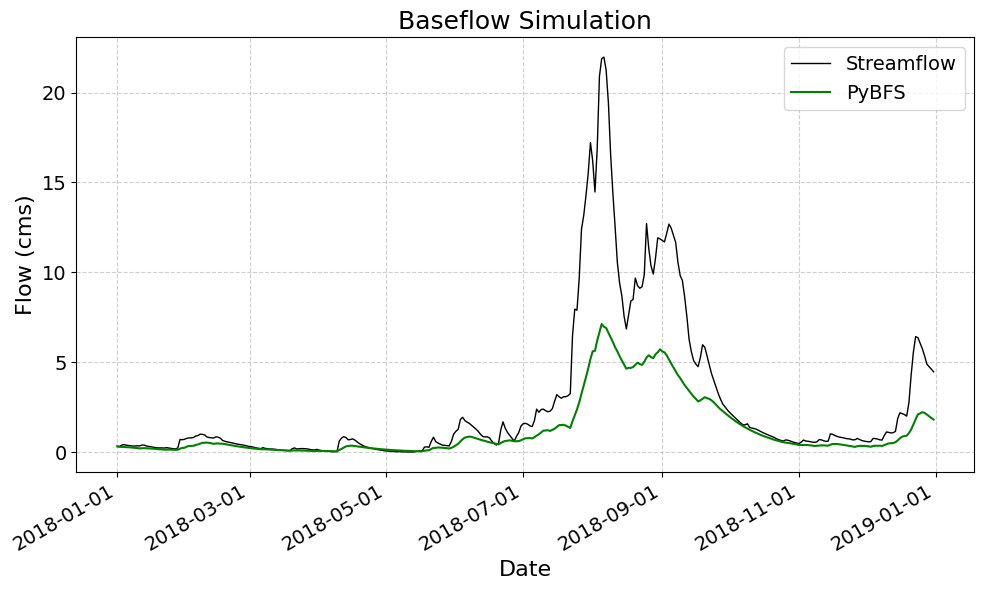

,date,streamflow,baseflow
0,2018-01-01,28869.54394,27816.594060
1,2018-01-02,27156.94387,25989.319760
2,2018-01-03,34252.00128,25467.992575
3,2018-01-04,36453.91565,25092.845465
4,2018-01-05,33762.68698,24842.349130
...,...,...,...
360,2018-12-27,462402.01730,188563.357115
361,2018-12-28,423256.87300,181217.331745
362,2018-12-29,411024.01540,172435.932100
363,2018-12-30,398791.15780,164080.060075


In [11]:
# Run PyBFS
print("\nRunning PyBFS baseflow separation...")
result = bfs.PyBFS(streamflow_data, SBT, basin_char, gw_hyd, flow)
print(f"PyBFS completed for {len(result)} time steps")

# Display summary statistics
print("\n=== Results Summary ===")
print(f"Total observed flow: {result['Qob'].sum():.2f}")
print(f"Total simulated flow: {result['Qsim'].sum():.2f}")
print(f"Total baseflow: {result['Baseflow'].sum():.2f}")
print(f"Total surface flow: {result['SurfaceFlow'].sum():.2f}")
print(f"Total direct runoff: {result['DirectRunoff'].sum():.2f}")

# Plot results
print("\nPlotting baseflow simulation...")
bfs.plot_baseflow_simulation(streamflow_data, result)

## Baseflow Forecasting


=== Running Forecast Example ===
Running PyBFS for calibration period (2018-01-01 to 2018-09-30)...
Initial conditions extracted from 2018-09-30 00:00:00

Forecasting for period 2018-10-01 to 2018-11-30...
Forecast completed for 61 time steps

Plotting forecast with observed streamflow...


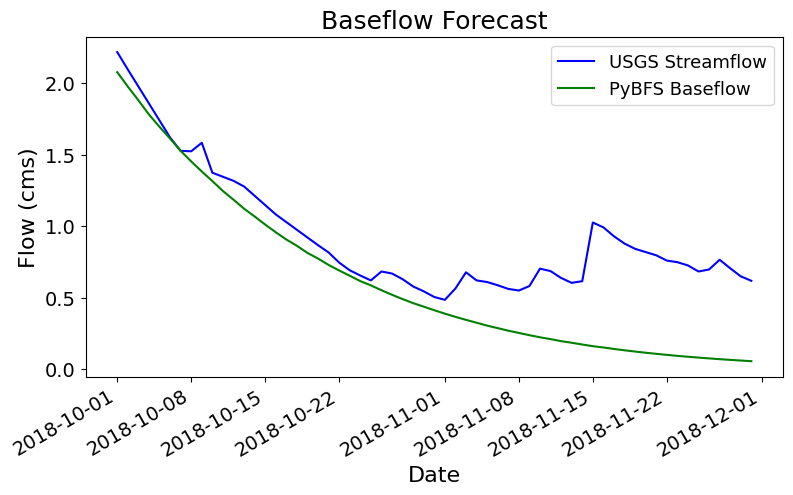

In [12]:
print("\n=== Running Forecast Example ===")

# Filter data for calibration period (Jan-Sep 2018)
start_date = '2018-01-01'
end_date = '2018-09-30'
streamflow_data['Date'] = pd.to_datetime(streamflow_data['Date'])
streamflow_data_filtered = streamflow_data[
    (streamflow_data['Date'] >= start_date) & (streamflow_data['Date'] <= end_date)
]

print(f"Running PyBFS for calibration period ({start_date} to {end_date})...")
tmp2 = bfs.PyBFS(streamflow_data_filtered, SBT, basin_char, gw_hyd, flow)

# Extract initial conditions from last time step
Xi, Zbi, Zsi, StBi, StSi, Surflow, Baseflow, Rech = tmp2.iloc[-1][
    ['X', 'Zb.L', 'Zs.L', 'StBase', 'StSur', 'SurfaceFlow', 'Baseflow', 'Rech']
]
ini = (Xi, Zbi, Zsi, StBi, StSi, Surflow, Baseflow, Rech)

print(f"Initial conditions extracted from {tmp2.iloc[-1]['Date']}")

# Create forecast period (Oct-Nov 2018)
dates = pd.date_range(start="2018-10-01", end="2018-11-30", freq="D")
forecast_df = pd.DataFrame({
    "date": dates,
    "streamflow": np.nan
})

print(f"\nForecasting for period 2018-10-01 to 2018-11-30...")
f = bfs.forecast(forecast_df, SBT, basin_char, gw_hyd, flow, ini)
print(f"Forecast completed for {len(f)} time steps")

# # Plot forecast
# print("\nPlotting baseflow forecast...")
# bfs.plot_forecast_baseflow(f)

# Plot forecast with observed data for comparison
forecast_start = '2018-10-01'
forecast_end = '2018-11-30'
streamflow_data_forecast = streamflow_data[
    (streamflow_data['Date'] >= forecast_start) & (streamflow_data['Date'] <= forecast_end)
]

print("\nPlotting forecast with observed streamflow...")
bfs.plot_forecast_baseflow_streamflow(f, streamflow_data_forecast)